# Where do reports come from?

In the districts notebook, we used the reported `beat_occurred` field to extract the district that reports came from, and analyzed rates of officer responses (arrival time, notification to missing persons or special victims unit, closure date). 

Here, we can explore the geography of reports and a few exploratory analytical questions.

examples:
- What regions experience the most missing persons reports (by `beat_occurred`)?
- How do rates of new reports change overtime for different regions (by `beat_occurred`)?
- How might `beat_assigned` be used to understand police deployment? Will `beat_occurred` always be more accurate?

In [1]:
# dependencies
import pandas as pd
import matplotlib.pyplot as plt 

import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import folium

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# support methods
def prep_mp(df):
    copy = df.copy().reset_index().drop(columns='index')
    copy.beat_occurred = copy.beat_occurred.astype(str).str.replace(".0", "")
    copy.loc[copy.beat_occurred.str.len() == 3, 
             'beat_occurred'] = "0" + copy.beat_occurred
    return copy

def prep_geodata(f):
    geo_df = gpd.read_file(f)
    current_crs = geo_df.crs
    geo_df.to_crs(epsg=3857, inplace=True)
    return geo_df

def add_fields(geo_df):
    assert 'geometry' in geo_df.columns
    copy = geo_df.copy()
    copy['area'] = copy.geometry.area
    return copy

In [3]:
mp = pd.read_parquet("../import/output/mp.parquet")
mp = prep_mp(mp)
extras = pd.read_parquet("../import/input/extras.parquet")

city_beats = pd.read_csv("../import/input/PoliceBeatDec2012.csv")
geo_gjs = prep_geodata("../import/input/Boundaries - Police Beats (current).geojson")
geo_gjs = add_fields(geo_gjs)

In [4]:
mp.sample(5)[['rd_no', 'date_occurred', 'race', 'sex', 'age_group']]

,rd_no,date_occurred,race,sex,age_group
32396,HL733703,2005-02-21 14:00:00,BLACK,F,youth (10-20)
323137,F087866,2000-02-12 16:00:00,BLACK,F,adult (21-59)
328425,HX345567,2014-07-13 15:00:00,BLACK,F,youth (10-20)
127896,HN311739,2007-04-27 23:30:00,BLACK,F,youth (10-20)
25805,F362863,2000-06-16 17:00:00,WHITE,F,youth (10-20)


In [5]:
geo_gjs.head()

,beat,beat_num,district,sector,geometry,area
0,1,1713,17,1,"MULTIPOLYGON (((-9763245.357 5157351.262, -976...",2.122702e+06
1,0,3100,31,0,"MULTIPOLYGON (((-9777597.699 5157288.429, -977...",1.446049e+07
2,5,1651,16,5,"MULTIPOLYGON (((-9785744.852 5157469.155, -978...",5.327867e+05
3,1,1914,19,1,"MULTIPOLYGON (((-9756587.641 5156445.788, -975...",2.140261e+06
4,1,1915,19,1,"MULTIPOLYGON (((-9755733.079 5155885.937, -975...",3.196374e+06


### location
- talk about last seen location, address, beat (or district) occurred
- **do certain areas of Chicago have more missing persons reports than others?** cross beat occurred with monthly counts of new rdnos

#### what are the valid district, sector, and beat values?

In [6]:
dists = city_beats.DISTRICT.unique()
sects = city_beats.SECTOR.unique()
beats = city_beats.BEAT.unique()

# note: sectors and beats both appear in range (0, 5) inclusive (shown in later step)
for i in range(0, max(dists)+1):
    print(f'{i} in city_dists:\t{i in dists}')

0 in city_dists:	False
1 in city_dists:	True
2 in city_dists:	True
3 in city_dists:	True
4 in city_dists:	True
5 in city_dists:	True
6 in city_dists:	True
7 in city_dists:	True
8 in city_dists:	True
9 in city_dists:	True
10 in city_dists:	True
11 in city_dists:	True
12 in city_dists:	True
13 in city_dists:	False
14 in city_dists:	True
15 in city_dists:	True
16 in city_dists:	True
17 in city_dists:	True
18 in city_dists:	True
19 in city_dists:	True
20 in city_dists:	True
21 in city_dists:	False
22 in city_dists:	True
23 in city_dists:	False
24 in city_dists:	True
25 in city_dists:	True
26 in city_dists:	False
27 in city_dists:	False
28 in city_dists:	False
29 in city_dists:	False
30 in city_dists:	False
31 in city_dists:	True


In [7]:
sects

array([1, 0, 5, 3, 2])

In [8]:
beats

array([1, 0, 5, 3, 2])

#### do all the beats we observe match the city's data? any invalid?

In [9]:
mp['short_beat_occurred'] = mp.beat_occurred.str.len() < 3
mp['short_beat_assigned'] = mp.beat_assigned.str.len() < 3

print('improperly short beat_occurred:\t', mp.short_beat_occurred.sum())
print('improperly short beat_assigned:\t', mp.short_beat_assigned.sum())

improperly short beat_occurred:	 0
improperly short beat_assigned:	 2


In [10]:
mp.loc[mp.beat_assigned.str.len() < 3, ['rd_no', 'beat_occurred', 'beat_assigned', 
                                        'race', 'sex', 'age', 'age_group', 'address', 
                                        'status', 'tta_group', 'ttc_group']]

,rd_no,beat_occurred,beat_assigned,race,sex,age,age_group,address,status,tta_group,ttc_group
95583,HS318761,0111,3N,None,None,NaN,None,"2XX S CANAL ST, CHICAGO",CLOSED NON-CRIMINAL,MISSING,MISSING
250341,HJ104231,1111,11,BLACK,F,17.0,youth (10-20),"44XX W THOMAS ST, CHICAGO",CLOSED NON-CRIMINAL,MISSING,MISSING


#### review valid beats

In [11]:
beats = mp[['rd_no', 'address', 
            'beat_occurred', 'beat_assigned', 
            'city_district_occurred', 'city_sector_occurred', 'city_beat_occurred',]
          ].copy()
beats.loc[beats.beat_assigned.str.len() == 3, 'beat_assigned'] = "0" + beats.beat_assigned
beats.loc[beats.beat_assigned.str.len() < 3, 'beat_assigned'] = None
beats

,rd_no,address,beat_occurred,beat_assigned,city_district_occurred,city_sector_occurred,city_beat_occurred
0,F012033,"63XX S KING DR, CHICAGO",0312,0312,3,1,2
1,F021758,"17XX N DRAKE AV, CHICAGO",1422,2502,14,2,2
2,F094577,"26XX N CALIFORNIA AV, CHICAGO",1411,1411,14,1,1
3,F121480,"7XX N ELIZABETH ST, CHICAGO",1324,1341,13,2,4
4,F118317,"48XX S INDIANA AV, CHICAGO",0224,0233,2,2,4
...,...,...,...,...,...,...,...
352906,HW137496,114XX S BISHOP ST,2234,6252,None,None,None
352907,HW220644,1XX N LOTUS AVE,1523,6253,None,None,None
352908,HW278331,33XX W FILLMORE ST,1134,6235,None,None,None
352909,HW530680,78XX S MORGAN ST,0612,6213,None,None,None


In [12]:
# how often is the beat_assigned the same as the occurence beat?
beats.loc[beats.beat_occurred == beats.beat_assigned].shape[0]

122791

In [13]:
# how often do beat_assigned and beat_occurred not match?
round(beats.loc[beats.beat_occurred != beats.beat_assigned].shape[0] / beats.shape[0], 2)

0.65

In [14]:
beats['temp_beat_assigned'] = beats.beat_assigned
beats['city_district_assigned'] = beats.temp_beat_assigned.str[:2]
beats['city_sector_assigned'] = beats.temp_beat_assigned.str[2]
beats['city_beat_assigned'] = beats.temp_beat_assigned.str[3:]
beats.drop(columns='temp_beat_assigned', inplace=True)

In [15]:
beats[['rd_no', 'address', 
       'beat_occurred', 'beat_assigned', 
       'city_district_occurred', 'city_sector_occurred', 'city_beat_occurred', 
       'city_district_assigned', 'city_sector_assigned', 'city_beat_assigned']]

,rd_no,address,beat_occurred,beat_assigned,city_district_occurred,city_sector_occurred,city_beat_occurred,city_district_assigned,city_sector_assigned,city_beat_assigned
0,F012033,"63XX S KING DR, CHICAGO",0312,0312,3,1,2,03,1,2
1,F021758,"17XX N DRAKE AV, CHICAGO",1422,2502,14,2,2,25,0,2
2,F094577,"26XX N CALIFORNIA AV, CHICAGO",1411,1411,14,1,1,14,1,1
3,F121480,"7XX N ELIZABETH ST, CHICAGO",1324,1341,13,2,4,13,4,1
4,F118317,"48XX S INDIANA AV, CHICAGO",0224,0233,2,2,4,02,3,3
...,...,...,...,...,...,...,...,...,...,...
352906,HW137496,114XX S BISHOP ST,2234,6252,None,None,None,62,5,2
352907,HW220644,1XX N LOTUS AVE,1523,6253,None,None,None,62,5,3
352908,HW278331,33XX W FILLMORE ST,1134,6235,None,None,None,62,3,5
352909,HW530680,78XX S MORGAN ST,0612,6213,None,None,None,62,1,3


In [16]:
beats.city_district_assigned.value_counts()

city_district_assigned
24    27703
20    20527
07    19452
02    19314
08    19115
      ...  
97        1
95        1
70        1
61        1
00        1
Name: count, Length: 72, dtype: int64

### what districts are observed outside of the city's guidelines?
Note: we've been advised that certain district numbers are used for airport zones \
Note 2: as with any region in a period over 20 years, these maps can change, so we should look to see if unexpected values are from a certain point in time.

In [17]:
for dist in beats.city_district_assigned:
    if pd.notnull(dist):
        if not all([char.isdigit() for char in dist]): print(dist)

5C
5C
5C


In [18]:
beats.loc[(beats.beat_assigned.notnull()) & 
          (beats.beat_assigned.str.contains('C'))
         ].head()

,rd_no,address,beat_occurred,beat_assigned,city_district_occurred,city_sector_occurred,city_beat_occurred,city_district_assigned,city_sector_assigned,city_beat_assigned
4332,HM233065,"97XX S OGLESBY AVE, CHICAGO",0431,0404C,4,3,1,04,0,4C
5838,JE194869,"130XX S DREXEL AVE, CHICAGO",0533,4578C,5,3,3,45,7,8C
9075,HL179003,"47XX N DRAKE AVE, CHICAGO",1723,1763C,17,2,3,17,6,3C
10615,HJ404858,"30XX W 21ST PL, CHICAGO",1022,1004C,10,2,2,10,0,4C
15227,HM607166,"6XX W DIVISION ST, CHICAGO",1822,4577C,18,2,2,45,7,7C


In [19]:
unk_dist = {}
for dist in beats.city_district_assigned.values:
    if pd.isna(dist): continue
    if (dist.isdigit()):
        clean = int(dist)
        if clean not in city_beats.DISTRICT.unique():
            if clean not in unk_dist: unk_dist[clean] = 1
            else: unk_dist[clean] += 1
unk_dist

{13: 4762,
 72: 14325,
 23: 10061,
 21: 4411,
 73: 325,
 29: 140,
 75: 227,
 45: 650,
 74: 92,
 52: 4128,
 55: 6,
 95: 1,
 83: 33,
 54: 20,
 53: 593,
 91: 523,
 57: 16,
 71: 61,
 51: 20,
 77: 13,
 44: 9,
 56: 3,
 41: 9,
 47: 11,
 93: 2,
 28: 3,
 82: 15,
 81: 17,
 26: 4,
 50: 1,
 76: 1,
 67: 5,
 62: 22,
 92: 5,
 80: 2,
 42: 14,
 0: 1,
 43: 5,
 78: 1,
 65: 2,
 79: 1,
 96: 1,
 32: 1,
 97: 1,
 58: 2,
 70: 1,
 61: 1,
 63: 2}

### same question but for sectors?

In [20]:
unk_sect = {}
for dist in beats.city_sector_assigned.values:
    if pd.isna(dist): continue
    if (dist.isdigit()):
        clean = int(dist)
        if clean not in city_beats.SECTOR.unique():
            if clean not in unk_sect: unk_sect[clean] = 1
            else: unk_sect[clean] += 1
unk_sect

{4: 18942, 7: 6140, 8: 1340, 6: 452, 9: 1249}

### same question but for beats?
Note: a "BEAT_NUM" is f"{DISTRICT}{SECTOR}{BEAT}"

In [21]:
unk_beat = {}
for dist in beats.city_beat_assigned.values:
    if pd.isna(dist): continue
    if (dist.isdigit()):
        clean = int(dist)
        if clean not in city_beats.BEAT.unique():
            if clean not in unk_beat: unk_beat[clean] = 1
            else: unk_beat[clean] += 1
unk_beat

{4: 42450,
 6: 8212,
 7: 6199,
 9: 2269,
 8: 2568,
 11: 1,
 74: 1,
 12: 1,
 72: 2,
 69: 1,
 71: 1}

### chars in beat_nums: an artifact of the supervisor?
Note: we've been advised the alphabetical characters we sometimes in the beat_nums refers to the initial of supervisor of that region at that point in time, since some of the canonical areas are divided that way

In [22]:
# how many unique beat_assigned values contain [A-Z]?
has_char = []
for assn in beats.beat_assigned.unique():
    if pd.isna(assn): continue
    if not all([char.isdigit() for char in assn]): has_char.append(assn)
len(has_char)

843

In [23]:
chars = {}
for val in has_char:
    clean = ''.join([v for v in val[-2:] if not v.isdigit()])
    if not clean: continue
    if clean not in chars: chars[clean] = 1
    else: chars[clean] += 1
chars

{'A': 116,
 'S': 90,
 'R': 429,
 'H': 30,
 'C': 41,
 'Z': 2,
 'D': 35,
 'B': 49,
 'W': 2,
 'F': 7,
 'K': 1,
 'HR': 6,
 'E': 13,
 'I': 3,
 'N': 1,
 'X': 1,
 'L': 2,
 'G': 4,
 'J': 1,
 'M': 2,
 'V': 1,
 'O': 1}

In [24]:
only_digits = [int(beat) 
               for beat in beats.loc[~beats.beat_assigned.isin(has_char), 'beat_assigned'].unique() 
               if beat]
len(only_digits)

1744

In [25]:
beats.loc[~beats.beat_assigned.isin(has_char), 'beat_assigned'].value_counts().sum()

325188

## plotting `beat_occurred`

In [26]:
beat_vc = mp[['rd_no', 'beat_occurred']].groupby('beat_occurred').count().reset_index()
beat_vc.rename(columns={'beat_occurred': 'beat_num', 
                        'rd_no': 'n_reports'}, inplace=True)
beat_vc

,beat_num,n_reports
0,0111,130
1,0112,41
2,0113,53
3,0114,73
4,0121,41
...,...,...
300,2532,1537
301,2533,1784
302,2534,1407
303,2535,1208


In [27]:
geo_pd = pd.merge(beat_vc, geo_gjs, on='beat_num', how='outer')
geo_gpd = gpd.GeoDataFrame(geo_pd)
geo_pd.area.describe()

count    2.770000e+02
mean     3.963240e+06
std      4.598805e+06
min      2.476008e+05
25%      1.790281e+06
50%      2.683263e+06
75%      4.379960e+06
max      4.877212e+07
Name: area, dtype: float64

In [28]:
# a majority of these missing geometry are districts that were changed after 2012
# representing some 21k records
# unclear how to resolve to salvage those reports for this mapping
geo_pd.loc[geo_pd.geometry.isna(), 'beat_num'].str[:2].value_counts()
geo_pd.loc[geo_pd.geometry.isna(), 'n_reports'].sum()

21329

<Axes: >

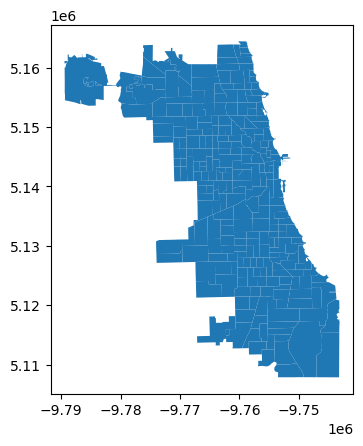

In [29]:
geo_gpd.plot()

In [30]:
geo_gpd

,beat_num,n_reports,beat,district,sector,geometry,area
0,0111,130,1,01,1,"MULTIPOLYGON (((-9754315.890 5144261.498, -975...",5.026277e+05
1,0112,41,1,01,1,"MULTIPOLYGON (((-9754408.181 5143502.892, -975...",4.046126e+05
2,0113,53,1,01,1,"MULTIPOLYGON (((-9754495.754 5142949.474, -975...",4.115397e+05
3,0114,73,1,01,1,"MULTIPOLYGON (((-9754300.463 5144345.320, -975...",3.145153e+06
4,0121,41,2,01,2,"MULTIPOLYGON (((-9755787.798 5143876.516, -975...",1.241985e+06
...,...,...,...,...,...,...,...
302,2534,1407,3,25,3,"MULTIPOLYGON (((-9765675.872 5148579.401, -976...",2.370117e+06
303,2535,1208,3,25,3,"MULTIPOLYGON (((-9764586.420 5148596.841, -976...",2.356927e+06
304,3100,12,0,31,0,"MULTIPOLYGON (((-9777597.699 5157288.429, -977...",1.446049e+07
305,3100,12,0,31,0,"MULTIPOLYGON (((-9776988.038 5158559.394, -977...",9.237106e+05


<Axes: >

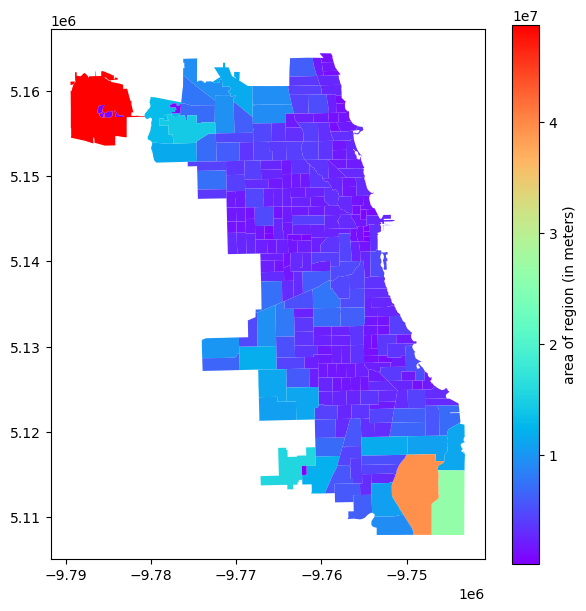

In [31]:
geo_gpd.plot(column='area', cmap='rainbow', legend=True,
                legend_kwds={'label': "area of region (in meters)"}, 
                figsize=(7, 7))

In [33]:
geo_gpd.n_reports.describe()

count     307.000000
mean     1149.625407
std      1071.088381
min         3.000000
25%       468.500000
50%       965.000000
75%      1479.500000
max      7606.000000
Name: n_reports, dtype: float64

<Axes: >

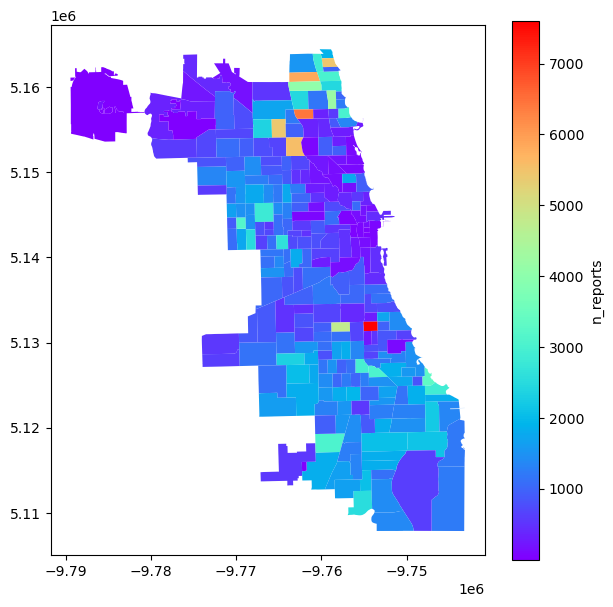

In [34]:
geo_gpd.plot(column='n_reports', cmap='rainbow', legend=True,
                legend_kwds={'label': "n_reports"}, 
                figsize=(7, 7))